## RNN model to predict whether a tweet is labelled in one of the following 3 categories: {sadness, neutral, happiness}.

## 1. Defining constants and imports

In [1]:
import os
import numpy as np
import pandas as pd

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'# Environment settings- deals with the library conflicts)
from keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional, LSTM
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
no_tweets = 19012      # no of tweets that will be read from file out of 40,000. 
max_tweets_length = 50 # no of words per tweets.  tweets will be  truncated or padded to be of this length.
max_words = 5000        # this is the size of the index (i.e. most common top words that will be used as features)
embedding_dim = 200     # length of embedding based on Glove

## 2. Reading the Data

In [3]:
# Reading data from CSV file
def read_from_tweets_file(file_path):
    tweets_file = pd.read_csv(file_path, on_bad_lines='skip')

    if 'content' not in tweets_file.columns or 'sentiment' not in tweets_file.columns:
        print("Missing required columns: 'content' or 'sentiment'")
        return pd.DataFrame()  
    
    # Count sentiment occurrences
    sentiment_counts = tweets_file['sentiment'].value_counts()
    print("\nSentiment counts:\n", sentiment_counts, '\n')

    return tweets_file


def read_data(file_path, no_tweets):
    df = read_from_tweets_file(file_path)

    #  sentiment index mapping
    sentiment_index = {"sadness": 0, "neutral": 1, "happiness": 2}

    # only include selected sentiments and limit to 'no_tweets' tweets
    df = df[df['sentiment'].isin(sentiment_index.keys())].head(no_tweets)

    # Extract tweet content andsentiment
    contents = df['content'].tolist()
    sentiments = df['sentiment'].map(sentiment_index).tolist()

    return contents, sentiments

In [4]:

file_path = "tweet_emotions.csv"
contents, sentiments = read_data(file_path, no_tweets)

# Print a sample to check
print("Check if contents and sentiments are aligned:")
for i in range(min(6, len(sentiments))):
    print(f"Tweet {i} - Sentiment: {sentiments[i]} - Content: {contents[i]}")

print("\nFirst 5 contents:", contents[:5])
print("\nFirst 5 sentiments:", sentiments[:5])



Sentiment counts:
 sentiment
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64 

Check if contents and sentiments are aligned:
Tweet 0 - Sentiment: 0 - Content: Layin n bed with a headache  ughhhh...waitin on your call...
Tweet 1 - Sentiment: 0 - Content: Funeral ceremony...gloomy friday...
Tweet 2 - Sentiment: 1 - Content: @dannycastillo We want to trade with someone who has Houston tickets, but no one will.
Tweet 3 - Sentiment: 0 - Content: I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!
Tweet 4 - Sentiment: 0 - Content: @charviray Charlene my love. I miss you
Tweet 5 - Sentiment: 0 - Content: @kelcouch I'm sorry  at least it's Friday?

First 5 contents: ['Layin n bed with a heada

## 3. Pre-processing the Data

In [5]:
#Tokenize the content
contents = [str(text) for text in contents]  # Ensure contents are strings
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(contents)

# Check how many unique words are in dataset
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens')

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(contents)

# Pad sequences
data = pad_sequences(sequences, maxlen=max_tweets_length)

ratings = np.asarray(sentiments)
#Print shapes of data and labels
print('Shape of Data =', data.shape)
print('Shape of Labels =', ratings.shape)

Found 29301 unique tokens
Shape of Data = (19012, 50)
Shape of Labels = (19012,)


In [ ]:
# random seed for reproducibility
np.random.seed(9)

#Balancing the dataset
samples_per_class = 10000 #Change to 5,000 if replace=False
balanced_indices = []

for label in [0, 1, 2]:  # fom sentiments
    class_idx = np.where(ratings == label)[0]
    selected = np.random.choice(class_idx, samples_per_class, replace=True)# Changd samples_per_class to 5,000 if replace=False
    balanced_indices.extend(selected)

np.random.shuffle(balanced_indices)

# Applyingthe balanced selection
data = data[balanced_indices]
ratings = ratings[balanced_indices]

#Shuffling indices and spliting into sets
total = len(ratings)
indices = np.arange(total)
np.random.shuffle(indices)

# splitting based on overrepresntation of neutral sentiments
train_end = int(0.65 * total)
val_end = int(0.95 * total)

x_train, y_train = data[indices[:train_end]], ratings[indices[:train_end]]
x_val, y_val = data[indices[train_end:val_end]], ratings[indices[train_end:val_end]]
x_test, y_test = data[indices[val_end:]], ratings[indices[val_end:]]

# Print dataset - should be balanced
print("Total tweets in dataset =", total)
print("Train set:", x_train.shape)
print("Validation set:", x_val.shape)
print("Test set:", x_test.shape)
print("Training set Distribution:", np.bincount(y_train))
print("Validation set Distribution:", np.bincount(y_val))
print("Test set Distribution:", np.bincount(y_test))


Total tweets in dataset = 60000
Train set: (39000, 50)
Validation set: (18000, 50)
Test set: (3000, 50)
Training set Distribution: [13010 13042 12948]
Validation set Distribution: [5999 5954 6047]
Test set Distribution: [ 991 1004 1005]


## 4. Loading the Glove Embeddings

In [ ]:
glove_dir = 'glove.6B'

embeddings_index = {}

f = open(os.path.join(glove_dir,'glove.6B.200d.txt'),encoding='utf-8') #change to 100d, 200d etc. if computer resources canmanage
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()

print('Number of words in glove embeddings =', len(embeddings_index))


Number of words in glove embeddings = 400000


In [8]:
#looking for word embeddings

embedding_matrix = np.zeros((max_words, embedding_dim))

for word,i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        

print("shape of embeddings matrix is:",  embedding_matrix.shape)

# print some entries    
for word,i in word_index.items():
    if i > 10: break 
    print(f'{i}:{word}\t--> { embedding_matrix[i, 0:6]}')



shape of embeddings matrix is: (5000, 200)
1:i	--> [ 0.26804999  0.36032    -0.33199999 -0.54641998 -0.50450999 -0.013461  ]
2:to	--> [ 0.57345998  0.54170001 -0.23477    -0.3624      0.40369999  0.11386   ]
3:the	--> [-0.071549  0.093459  0.023738 -0.090339  0.056123  0.32547 ]
4:a	--> [ 0.24168999 -0.34534001 -0.22307    -1.29069996  0.25285    -0.55128002]
5:my	--> [ 0.30379999  0.18126     0.46583    -0.66439998 -0.44069999  0.17174   ]
6:and	--> [0.20327    0.47347999 0.050877   0.002103   0.060547   0.33065999]
7:you	--> [ 0.85395002  0.57146001 -0.023652   -0.11047    -0.1275      0.085129  ]
8:it	--> [ 0.21631999  0.21896     0.12569    -0.17436001  0.17336001 -0.043868  ]
9:is	--> [ 0.32927999  0.25525999  0.26752999 -0.084809    0.29764     0.062339  ]
10:in	--> [-0.10272     0.30410001 -0.13576999 -0.27979001 -0.40926    -0.26552999]


## 5. Defining the network

In [9]:
RNN_network = Sequential()
RNN_network.add(Embedding(max_words, embedding_dim, input_length=max_tweets_length, weights=[embedding_matrix], trainable=False))
RNN_network.add(SimpleRNN(32))
RNN_network.add(Dropout(0.5))  
RNN_network.add(Dense(3, activation='softmax'))
RNN_network.summary()

LSTM_network = Sequential()
LSTM_network.add(Embedding(max_words, embedding_dim, input_length=max_tweets_length, weights=[embedding_matrix], trainable=False))
LSTM_network.add(LSTM(32))
LSTM_network.add(Dropout(0.5))  
LSTM_network.add(Dense(3, activation='softmax'))
LSTM_network.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 200)           1000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                7456      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 1,007,555
Trainable params: 7,555
Non-trainable params: 1,000,000
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedd

## 6. Training the networks

In [10]:
#TRAINING THE LSTM
LSTM_network.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print("Unique classes in y_train:", np.unique(y_train))
print("Unique classes in y_test:", np.unique(y_test))
print(f"Number of training tweets: {len(x_train)}")


callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True),#stops when val_loss doesn't improve over 4 epochsthen  restores best weights to the model
    ModelCheckpoint('best_model.h5', save_best_only=True),#saves the best models
    ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5)#reduces learning rate before earlystopping kicks in
]

#RNN_hist = best_model.fit(x_train, y_train,epochs=20, validation_data=(x_val, y_val), callbacks=callbacks,verbose=2,shuffle=True)
LSTM_hist = LSTM_network.fit(x_train, y_train, epochs=24,batch_size=32, validation_data=(x_val, y_val), callbacks=callbacks,verbose=2,shuffle=True)
import pickle
with open('LSTM_training_history.pkl', 'wb') as f:
    pickle.dump(LSTM_hist.history, f)

Unique classes in y_train: [0 1 2]
Unique classes in y_test: [0 1 2]
Number of training tweets: 39000
Epoch 1/24
1219/1219 - 71s - loss: 0.9124 - accuracy: 0.5765 - val_loss: 0.8248 - val_accuracy: 0.6359 - lr: 0.0010 - 71s/epoch - 58ms/step
Epoch 2/24
1219/1219 - 65s - loss: 0.8177 - accuracy: 0.6401 - val_loss: 0.7802 - val_accuracy: 0.6564 - lr: 0.0010 - 65s/epoch - 54ms/step
Epoch 3/24
1219/1219 - 67s - loss: 0.7760 - accuracy: 0.6648 - val_loss: 0.7487 - val_accuracy: 0.6715 - lr: 0.0010 - 67s/epoch - 55ms/step
Epoch 4/24
1219/1219 - 67s - loss: 0.7347 - accuracy: 0.6833 - val_loss: 0.7140 - val_accuracy: 0.6889 - lr: 0.0010 - 67s/epoch - 55ms/step
Epoch 5/24
1219/1219 - 68s - loss: 0.6995 - accuracy: 0.7055 - val_loss: 0.6883 - val_accuracy: 0.7077 - lr: 0.0010 - 68s/epoch - 56ms/step
Epoch 6/24
1219/1219 - 67s - loss: 0.6633 - accuracy: 0.7249 - val_loss: 0.6566 - val_accuracy: 0.7245 - lr: 0.0010 - 67s/epoch - 55ms/step
Epoch 7/24
1219/1219 - 68s - loss: 0.6319 - accuracy: 0.74

In [11]:
#TRAINING THE RNN
RNN_network.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print("Unique classes in y_train:", np.unique(y_train))
print("Unique classes in y_test:", np.unique(y_test))
print(f"Number of training tweets: {len(x_train)}")


callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True),#stops when val_loss doesn't improve over 4 epochsthen  restores best weights to the model
    ModelCheckpoint('best_model.h5', save_best_only=True),#saves the best models
    ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5)#reduces learning rate before earlystopping kicks in
]

#RNN_hist = best_model.fit(x_train, y_train,epochs=20, validation_data=(x_val, y_val), callbacks=callbacks,verbose=2,shuffle=True)
RNN_hist = RNN_network.fit(x_train, y_train, epochs=24,batch_size=32, validation_data=(x_val, y_val), callbacks=callbacks,verbose=2,shuffle=True)
import pickle
with open('RNN_training_history.pkl', 'wb') as f:
    pickle.dump(RNN_hist.history, f)

Unique classes in y_train: [0 1 2]
Unique classes in y_test: [0 1 2]
Number of training tweets: 39000
Epoch 1/24
1219/1219 - 39s - loss: 1.0504 - accuracy: 0.4733 - val_loss: 0.9493 - val_accuracy: 0.5570 - lr: 0.0010 - 39s/epoch - 32ms/step
Epoch 2/24
1219/1219 - 35s - loss: 0.9259 - accuracy: 0.5804 - val_loss: 0.8769 - val_accuracy: 0.6106 - lr: 0.0010 - 35s/epoch - 29ms/step
Epoch 3/24
1219/1219 - 32s - loss: 0.9022 - accuracy: 0.6018 - val_loss: 0.8713 - val_accuracy: 0.6166 - lr: 0.0010 - 32s/epoch - 26ms/step
Epoch 4/24
1219/1219 - 35s - loss: 0.8854 - accuracy: 0.6119 - val_loss: 0.8564 - val_accuracy: 0.6217 - lr: 0.0010 - 35s/epoch - 29ms/step
Epoch 5/24
1219/1219 - 35s - loss: 0.9115 - accuracy: 0.5882 - val_loss: 0.8714 - val_accuracy: 0.6137 - lr: 0.0010 - 35s/epoch - 29ms/step
Epoch 6/24
1219/1219 - 36s - loss: 0.8705 - accuracy: 0.6198 - val_loss: 0.8360 - val_accuracy: 0.6351 - lr: 0.0010 - 36s/epoch - 29ms/step
Epoch 7/24
1219/1219 - 36s - loss: 0.8541 - accuracy: 0.62

In [13]:
#Evaluate RNN
rnn_test_loss, rnn_test_accuracy = RNN_network.evaluate(x_test, y_test, verbose=0)
rnn_y_pred_probs = RNN_network.predict(x_test)
rnn_y_pred_classes = rnn_y_pred_probs.argmax(axis=1)

# Evaluate LSTM
lstm_test_loss, lstm_test_accuracy = LSTM_network.evaluate(x_test, y_test, verbose=0)
lstm_y_pred_probs = LSTM_network.predict(x_test)
lstm_y_pred_classes = lstm_y_pred_probs.argmax(axis=1)

# Display test results
print(f"\n--- Test Results ---")
print(f"RNN Accuracy:  {rnn_test_accuracy:.4f} | Loss: {rnn_test_loss:.4f}")
print(f"LSTM Accuracy: {lstm_test_accuracy:.4f} | Loss: {lstm_test_loss:.4f}")

# Displaying a few predictons from both 
print("\n/// Sample Predictions \\")
for i in np.random.choice(len(y_test), size=10, replace=False):
    print(f"Tweet {i+1}: RNN Predicted = {rnn_y_pred_classes[i]}, LSTM Predicted = {lstm_y_pred_classes[i]}, Actual = {y_test[i]}")



94/94 [==============================] - 1s 10ms/step

--- Test Results ---
RNN Accuracy:  0.6863 | Loss: 0.7473
LSTM Accuracy: 0.8457 | Loss: 0.4656

/// Sample Predictions \
Tweet 2946: RNN Predicted = 2, LSTM Predicted = 2, Actual = 2
Tweet 2840: RNN Predicted = 2, LSTM Predicted = 1, Actual = 1
Tweet 495: RNN Predicted = 0, LSTM Predicted = 0, Actual = 0
Tweet 2120: RNN Predicted = 0, LSTM Predicted = 0, Actual = 0
Tweet 386: RNN Predicted = 0, LSTM Predicted = 0, Actual = 0
Tweet 2165: RNN Predicted = 0, LSTM Predicted = 1, Actual = 1
Tweet 182: RNN Predicted = 2, LSTM Predicted = 2, Actual = 2
Tweet 1832: RNN Predicted = 2, LSTM Predicted = 2, Actual = 2
Tweet 2853: RNN Predicted = 0, LSTM Predicted = 0, Actual = 0
Tweet 2252: RNN Predicted = 1, LSTM Predicted = 1, Actual = 0


##  6. Plotting results

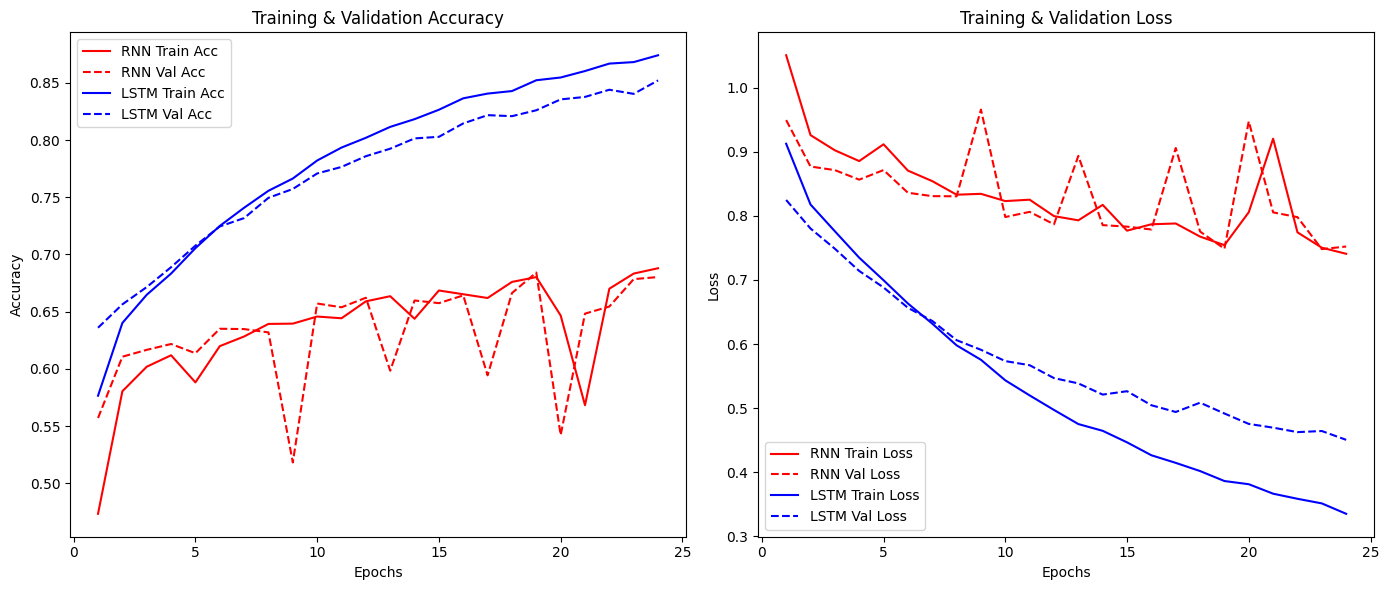

In [14]:
import matplotlib.pyplot as plt

# Loading history
with open('RNN_training_history.pkl', 'rb') as f:
    rnn_history = pickle.load(f)
with open('LSTM_training_history.pkl', 'rb') as f:
    lstm_history = pickle.load(f)

epochs = range(1, len(rnn_history['accuracy']) + 1)

# Plotting accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, rnn_history['accuracy'], 'r', label='RNN Train Acc')
plt.plot(epochs, rnn_history['val_accuracy'], 'r--', label='RNN Val Acc')
plt.plot(epochs, lstm_history['accuracy'], 'b', label='LSTM Train Acc')
plt.plot(epochs, lstm_history['val_accuracy'], 'b--', label='LSTM Val Acc')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, rnn_history['loss'], 'r', label='RNN Train Loss')
plt.plot(epochs, rnn_history['val_loss'], 'r--', label='RNN Val Loss')
plt.plot(epochs, lstm_history['loss'], 'b', label='LSTM Train Loss')
plt.plot(epochs, lstm_history['val_loss'], 'b--', label='LSTM Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()